## MultiCore Computing

A demonstration of how to take advantage of multiple cores as well as numba's just in time compilation. Must run this part using python 3 to take advantage of concurrent.futures

In [128]:
import concurrent.futures

In [129]:
from __future__ import print_function, division, absolute_import
import math
import threading
import time
from timeit import repeat
import matplotlib.pyplot as plt

import numpy as np
from numba import jit,boolean,int32

import concurrent.futures



In [130]:
size = 32
M = 100
num_processes = 4
numbers = M*np.ones(size,dtype=int)

print("N = {}".format(size))
print("num processes = {}".format(num_processes))

@jit(int32(int32),nopython=True,nogil=True,cache=True)
def looping_jit(n):
	tot = 0
	for i in range(n):
		for j in range(n):
			# for k in range(M):
				# for l in range(M):
			if i != 1 and j != 1:
				tot += i
	return tot

def looping(n):
	tot = 0
	for i in range(n):
		for j in range(n):
			# for k in range(M):
				# for l in range(M):
			if i != 1 and j != 1:
				tot += i
	return tot

test_fn = looping




N = 32
num processes = 4


In [131]:
def execute_timing(func,args,execution_type="serial"):
    ret = -1.0
    if execution_type == "serial":
        start = time.time()
        results = list(map(func,args))
        ret = time.time()-start
    elif execution_type == "multiprocessing":
        with concurrent.futures.ProcessPoolExecutor(num_processes) as executor:
            start = time.time()
            results =  list(executor.map(func, args))
            ret = time.time()-start
    elif execution_type == "threading":
        with concurrent.futures.ThreadPoolExecutor(num_processes) as executor:
            start = time.time()
            results =  list(executor.map(func, args))
            ret = time.time()-start
    else:
        raise Exception("unknown execution type. exiting.")
    return ret

In [132]:
# M_arr = np.logspace(np.log10(10),np.log10(1000),10,dtype=int)#[10,20,40,80,160])
#Run the timing tests#
type_arr = ["serial","multiprocessing","threading"]
funcs_arr = [looping,looping_jit]
num_spacings = 20
M_arr_nojit = np.logspace(np.log10(10),np.log10(400),num_spacings,dtype=int)#[10,20,40,80,160])
M_arr_jit = np.logspace(np.log10(10),np.log10(10000),num_spacings,dtype=int)#[10,20,40,80,160])

results = np.zeros((len(funcs_arr),len(type_arr),len(M_arr_jit)))

for i,func in enumerate(funcs_arr):
    for j,execution_type in enumerate(type_arr):
        M_arr = M_arr_nojit if i == 0 else M_arr_jit
        for k,M in enumerate(M_arr):
            pass
            results[i,j,k] = execute_timing(func,M*np.ones(size,dtype=int),execution_type)
            
    


In [133]:
def get_n_squared_estimate(x_arr,timing_arr):
    return timing_arr[-1]*x_arr**2/(x_arr[-1]**2)

no jit
speedup serial : 1.0
speedup multiprocessing : 2.67107411833
speedup threading : 0.788314045502
numba jit
speedup serial : 1.0
speedup multiprocessing : 2.95585128241
speedup threading : 3.75315498562


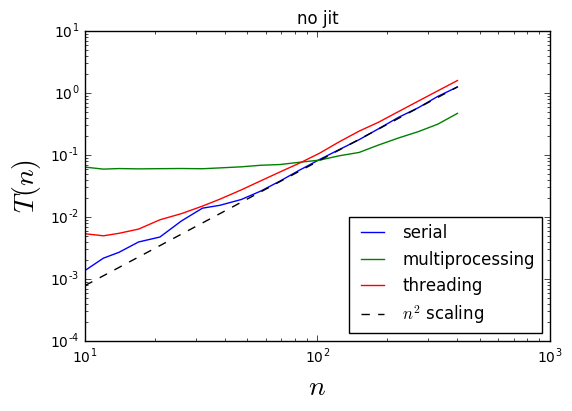

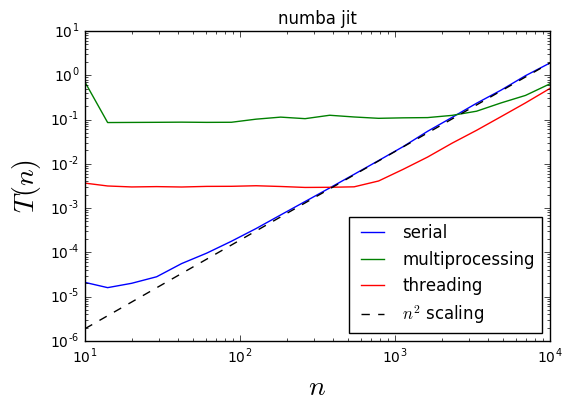

jit speedup: 413.469601353


In [139]:

speedup_jit = get_n_squared_estimate(M_arr_nojit,results[0,0,:])[0]/get_n_squared_estimate(M_arr_jit,results[1,0,:])[0]
colors = ["b","g","r"]

plt.close('all')
for i,func in enumerate(funcs_arr):
    print("no jit" if i == 0 else "numba jit")
    plt.figure(i)
    M_arr = M_arr_nojit if i == 0 else M_arr_jit
    for j,execution_type in enumerate(type_arr):
        plt.loglog(M_arr,results[i,j,:],"-"+colors[j],fillstyle="none",label=execution_type)
        print("speedup {} : {}".format(execution_type,results[i,0,-1]/results[i,j,-1]))
    plt.loglog(M_arr,get_n_squared_estimate(M_arr,results[i,0,:]),"--k",label="$n^2$ scaling")
    plt.title("numba jit" if i == 1 else "no jit")
    plt.legend(loc="lower right")
    plt.xlabel("$n$",size=20)
    plt.ylabel("$T(n)$",size=20)
#     plt.xlim([10**1,10**4])
#     plt.ylim([10**-6,10**1])
plt.show()


print("jit speedup: {}".format(speedup_jit))
        

## ArrayFire

For this section we need to have ArrayFire and OpenCL installed

In [53]:
#from https://github.com/arrayfire/arrayfire-python/blob/devel/examples/benchmarks/bench_fft.py
import arrayfire as af
import sys
from time import time
import numpy as np
import matplotlib.pyplot as plt

In [125]:
def calc_arrayfire(n):
    A = af.randu(n, n)
    af.sync()

    def run(iters):
        for t in range(iters):
            B = af.fft2(A)##that's all!

        af.sync()

    return run


def calc_numpy(n):
    np.random.seed(1)
    A = np.random.rand(n, n).astype(np.float32)

    def run(iters):
        for t in range(iters):
            B = np.fft.fft2(A)

    return run

def get_n_squared_log_n_estimate(x_arr,timing_arr):
    return timing_arr[-1]*n_sq_log_n(x_arr)/n_sq_log_n(x_arr[-1])

def n_sq_log_n(n):
    return n**2*np.log(n)


def bench(calc, iters=100, upto=13):
    _, name = calc.__name__.split("_")
    print("Benchmark N x N 2D fft on %s" % name)
    ts = []
    ns = []

    for M in range(6, upto):
        N = 1 << M
        run = calc(N)
        start = time()
        run(iters)
        t = (time() - start) / iters
        gflops = (10.0 * N * N * M) / (t * 1E9)
        print("Performance for %4d x %4d: %0.4f Gflops" % (N, N, gflops))
        ts.append(t)
        ns.append(N)
    return np.array(ts),np.array(ns)




In [92]:
af.info()
af.device_info()
iters = 50
ts_af,ns_af = bench(calc_arrayfire, iters = iters,upto=14)
ts_np,ns_np = bench(calc_numpy, iters = iters,upto=13)

Benchmark N x N 2D fft on arrayfire
Performance for   64 x   64: 0.6958 Gflops
Performance for  128 x  128: 2.7081 Gflops
Performance for  256 x  256: 9.7742 Gflops
Performance for  512 x  512: 24.5071 Gflops
Performance for 1024 x 1024: 52.8149 Gflops
Performance for 2048 x 2048: 73.3363 Gflops
Performance for 4096 x 4096: 88.6103 Gflops
Performance for 8192 x 8192: 60.0169 Gflops
Benchmark N x N 2D fft on numpy
Performance for   64 x   64: 1.6467 Gflops
Performance for  128 x  128: 2.5099 Gflops
Performance for  256 x  256: 3.5687 Gflops
Performance for  512 x  512: 2.3251 Gflops
Performance for 1024 x 1024: 1.7559 Gflops
Performance for 2048 x 2048: 1.7731 Gflops
Performance for 4096 x 4096: 1.5167 Gflops


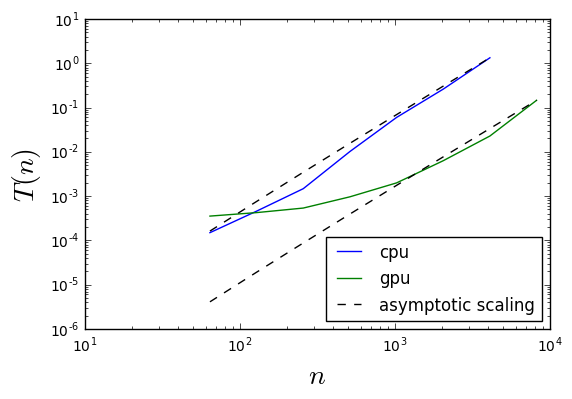

asymptotic speedup: 39.6x


In [126]:

plt.loglog(ns_np,ts_np,label="cpu")
plt.loglog(ns_af,ts_af,label="gpu")
plt.loglog(ns_af,get_n_squared_log_n_estimate(ns_af,ts_af),"--k",label="asymptotic scaling")
plt.loglog(ns_np,get_n_squared_log_n_estimate(ns_np,ts_np),"--k")

# plt.title("numba jit" if i == 1 else "no jit")
plt.legend(loc="lower right")
plt.xlabel("$n$",size=20)
plt.ylabel("$T(n)$",size=20)
plt.show()
speedup_gpu = get_n_squared_log_n_estimate(ns_np,ts_np)[0]/get_n_squared_log_n_estimate(ns_af,ts_af)[0]
print("asymptotic speedup: {:.1f}x".format(speedup_gpu))


In [112]:
n = 2000
B_af =0
B = 0
A = np.random.rand(n, n).astype(np.float32);
A_af = af.np_to_af_array(A); af.sync()
# A_af = af.randu(n, n); af.sync()
%timeit B_af = af.fft2(A_af);af.sync();
%timeit B = np.fft.fft2(A);
#np.array(B_af),np.array(B)


100 loops, best of 3: 5.86 ms per loop
1 loop, best of 3: 195 ms per loop


In [124]:
# af.display(af.np_to_af_array(np.zeros(10)))
B_af = af.fft2(A_af);af.sync();
B = np.fft.fft2(A);

print(np.array(B_af)[0:2,1])
print(np.array(B)[0:2,1])

[ 156.63244629-652.47595215j  405.70535278 +38.87200546j]
[ 156.63241773-652.47519733j  405.70537556 +38.87197862j]
